<a href="https://colab.research.google.com/github/SauloHenriqueAguiar/backtestBacktrading/blob/main/fastquant/SMAeRSIEtherHoratraderMaioaDezembro2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Backtest usando fastquant

In [147]:
#instalando fastquant
!pip install fastquant

#Pega dados da Binance

In [148]:
# preço do bitcoin
from fastquant import get_crypto_data

crypto = get_crypto_data("ETH/USDT", 
                         "2021-05-15", 
                         "2021-12-10",
                         time_resolution='1h'
                        )

In [149]:
crypto.tail()

,open,high,low,close,volume
dt,,,,,
2021-12-09 20:00:00,4122.46,4131.25,4076.16,4123.30,23691.0941
2021-12-09 21:00:00,4123.30,4177.71,4108.84,4164.33,16040.5598
2021-12-09 22:00:00,4164.34,4202.76,4138.97,4166.82,14961.8299
2021-12-09 23:00:00,4166.82,4187.77,4103.48,4105.64,13122.1677
2021-12-10 00:00:00,4105.64,4199.87,4100.00,4119.36,29631.3659


#Executando Backtesting com conjunto de valores

In [150]:
# Usando Cruzamento de Médias Móveis 
from fastquant import backtest

results = backtest('smac', 
                   crypto, 
                   fast_period=[7,14,21,28], 
                   slow_period=[30,45,60,75],
                   plot=False,
                   verbose=False
                  )

In [151]:
#tabela de resultados
results.head()

,strat_id,init_cash,buy_prop,sell_prop,fractional,slippage,single_position,commission,stop_loss,stop_trail,take_profit,execution_type,channel,symbol,allow_short,short_max,add_cash_amount,add_cash_freq,invest_div,fast_period,slow_period,rtot,ravg,rnorm,rnorm100,len,drawdown,moneydown,max,maxdrawdown,maxdrawdownperiod,sharperatio,pnl,final_value,total,win_rate,won,lost,won_avg,won_avg_prcnt,lost_avg,lost_avg_prcnt,won_max,won_max_prcnt,lost_max,lost_max_prcnt
0,2,100000,1,1,False,0.001,None,0,0,0,0,close,,,False,1.5,0,M,True,7,60,0.307077,0.001462,0.445553,44.555335,1190,15.250419,24462.79,"{'len': 1277, 'drawdown': 28.81820340918083, '...",25.143019,57,None,35944.54,135944.54,62,0.370968,23,39,7175.853478,7.175853,-3310.258718,-3.310259,19173.70,19.17370,-9114.93,-9.11493
1,1,100000,1,1,False,0.001,None,0,0,0,0,close,,,False,1.5,0,M,True,7,45,0.269502,0.001283,0.381822,38.182173,1190,20.776261,34336.45,"{'len': 1717, 'drawdown': 28.5957622686412, 'm...",23.997140,70,None,30931.26,130931.26,76,0.315789,24,52,7797.485833,7.797486,-3004.007692,-3.004008,19296.70,19.29670,-9681.21,-9.68121
2,8,100000,1,1,False,0.001,None,0,0,0,0,close,,,False,1.5,0,M,True,21,30,0.241980,0.001152,0.336931,33.693056,739,26.413379,45721.01,"{'len': 2535, 'drawdown': 37.09039837159718, '...",35.320346,99,None,27376.91,127376.91,96,0.416667,40,56,4624.564000,4.624564,-2814.386607,-2.814387,15763.95,15.76395,-10374.21,-10.37421
3,0,100000,1,1,False,0.001,None,0,0,0,0,close,,,False,1.5,0,M,True,7,30,0.206869,0.000985,0.281772,28.177167,1190,20.915030,32524.21,"{'len': 2396, 'drawdown': 27.98476972840872, '...",26.003559,72,None,22982.19,122982.19,104,0.346154,36,68,5683.746389,5.683746,-2671.068824,-2.671069,19962.45,19.96245,-11095.76,-11.09576
4,3,100000,1,1,False,0.001,None,0,0,0,0,close,,,False,1.5,0,M,True,7,75,0.190130,0.000905,0.256281,25.628128,1190,17.745245,26091.16,"{'len': 1424, 'drawdown': 27.859821457646355, ...",25.621153,67,None,20940.68,120940.68,52,0.403846,21,31,5930.858571,5.930859,-3342.172581,-3.342173,18407.36,18.40736,-9426.00,-9.42600


In [152]:
#pega os melhores parâmetros da linha superior(anterior)
fast_best, slow_best = results.iloc[0][["fast_period","slow_period"]]
fast_best, slow_best

(7, 60)

#Roda o Backtest usando os valores ótimos encontrados anteriormente

In [153]:
import matplotlib as pl
pl.style.use("default")
pl.rcParams["figure.figsize"] = (9,5)

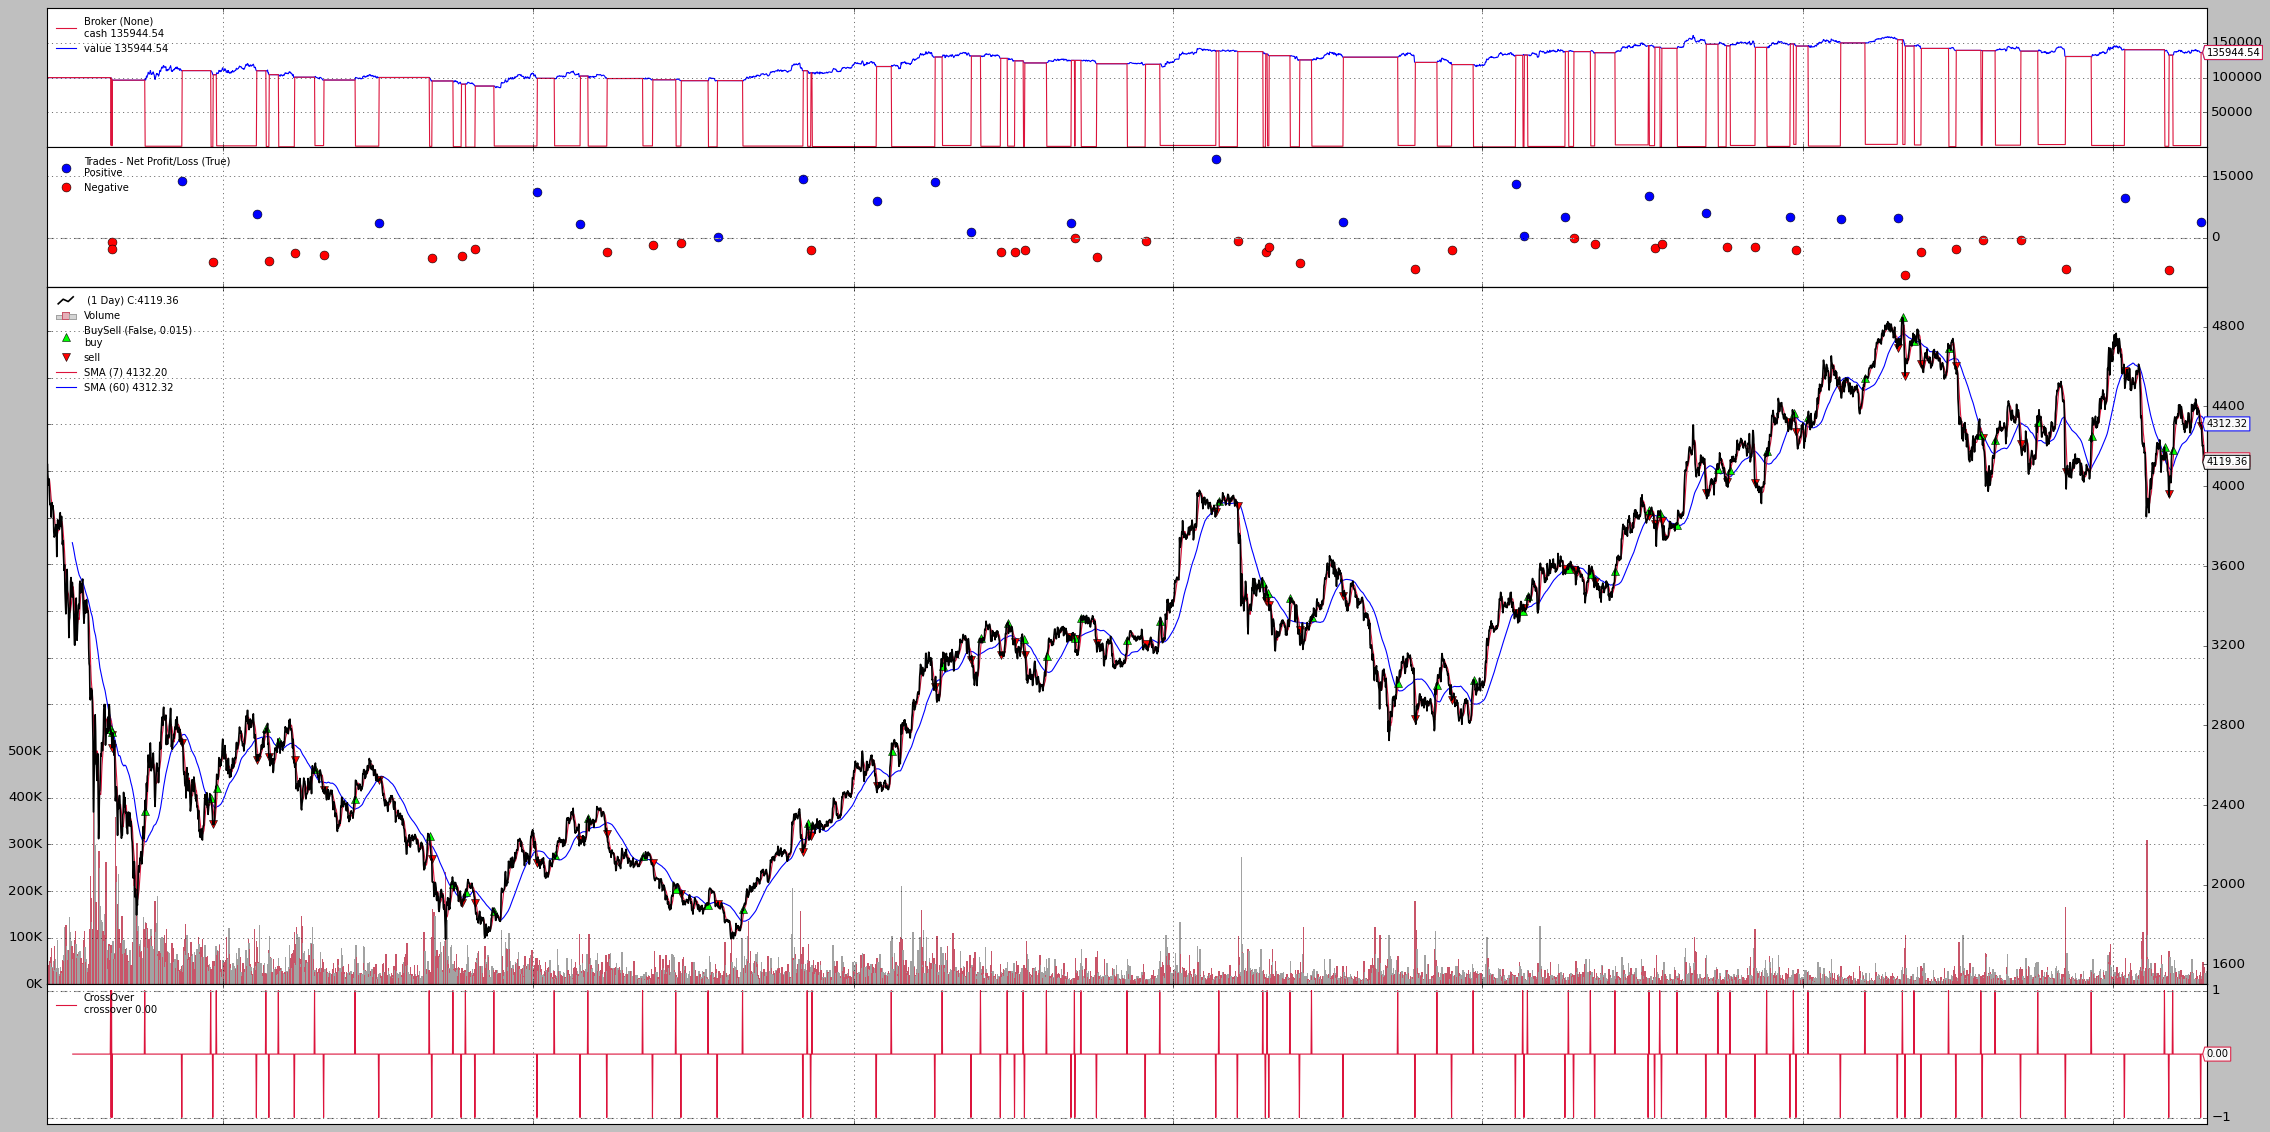

In [154]:
#mostra resultados com novos valores otimizados
results = backtest('smac', 
                   crypto, 
                   fast_period=fast_best, 
                   slow_period=slow_best,
                   plot=True,
                   verbose=False
                  )

#Acessando histórico de transações
Isso é feito definindo return_history = True.

##Estratégia Simples

In [155]:
results, history = backtest('smac', 
                               crypto, 
                               fast_period=fast_best, 
                               slow_period=slow_best,
                               plot=False,
                               verbose=False,
                               return_history=True
                              )

In [156]:
results

,strat_id,init_cash,buy_prop,sell_prop,fractional,slippage,single_position,commission,stop_loss,stop_trail,take_profit,execution_type,channel,symbol,allow_short,short_max,add_cash_amount,add_cash_freq,invest_div,fast_period,slow_period,rtot,ravg,rnorm,rnorm100,len,drawdown,moneydown,max,maxdrawdown,maxdrawdownperiod,sharperatio,pnl,final_value,total,win_rate,won,lost,won_avg,won_avg_prcnt,lost_avg,lost_avg_prcnt,won_max,won_max_prcnt,lost_max,lost_max_prcnt
0,0,100000,1,1,False,0.001,None,0,0,0,0,close,,,False,1.5,0,M,True,7,60,0.307077,0.001462,0.445553,44.555335,1190,15.250419,24462.79,"{'len': 1277, 'drawdown': 28.81820340918083, '...",25.143019,57,None,35944.54,135944.54,62,0.370968,23,39,7175.853478,7.175853,-3310.258718,-3.310259,19173.7,19.1737,-9114.93,-9.11493


 melhor ROI é de 35%

In [157]:
history.keys()

dict_keys(['orders', 'periodic', 'indicators'])

In [158]:
orders = history['orders']
orders

,strat_id,strat_name,dt,type,price,size,value,commission,pnl
0,0,fast_period7_slow_period60,2021-05-21 05:00:00,buy,2779.68,35,97288.80,0.0,0.00
1,0,fast_period7_slow_period60,2021-05-21 06:00:00,sell,2752.36,-35,97288.80,0.0,-956.20
2,0,fast_period7_slow_period60,2021-05-21 07:00:00,buy,2765.01,35,96775.35,0.0,0.00
3,0,fast_period7_slow_period60,2021-05-21 08:00:00,sell,2686.96,-35,96775.35,0.0,-2731.75
4,0,fast_period7_slow_period60,2021-05-24 12:00:00,buy,2367.74,40,94709.60,0.0,0.00
...,...,...,...,...,...,...,...,...,...
119,0,fast_period7_slow_period60,2021-12-02 03:00:00,sell,4576.79,-30,127557.90,0.0,9745.80
120,0,fast_period7_slow_period60,2021-12-06 00:00:00,buy,4196.44,33,138482.52,0.0,0.00
121,0,fast_period7_slow_period60,2021-12-06 10:00:00,sell,3960.68,-33,138482.52,0.0,-7780.08
122,0,fast_period7_slow_period60,2021-12-06 19:00:00,buy,4183.68,31,129694.08,0.0,0.00


O valor final dos resultados pode ser calculado a partir da comissão e pnl (lucro e perda = profit e loss) de todas as transações fechadas (compradas e vendidas) no histórico:

In [159]:
r = results.squeeze()
r.final_value

135944.5400000002

In [160]:
r.init_cash + orders.pnl.sum() - orders.commission.sum()

135944.54000000012

ROI de 35%

# estratégia de sinal único com pesquisa de grade

In [161]:
results, history = backtest('smac', 
                               crypto, 
                               fast_period=[7,14,21], 
                               slow_period=[30,45,60],
                               plot=False,
                               verbose=False,
                               return_history=True
                              )

In [162]:
orders = history['orders']
orders.strat_id.unique(), orders.strat_name.unique()

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array(['fast_period7_slow_period30', 'fast_period7_slow_period45',
        'fast_period7_slow_period60', 'fast_period14_slow_period30',
        'fast_period14_slow_period45', 'fast_period14_slow_period60',
        'fast_period21_slow_period30', 'fast_period21_slow_period45',
        'fast_period21_slow_period60'], dtype=object))

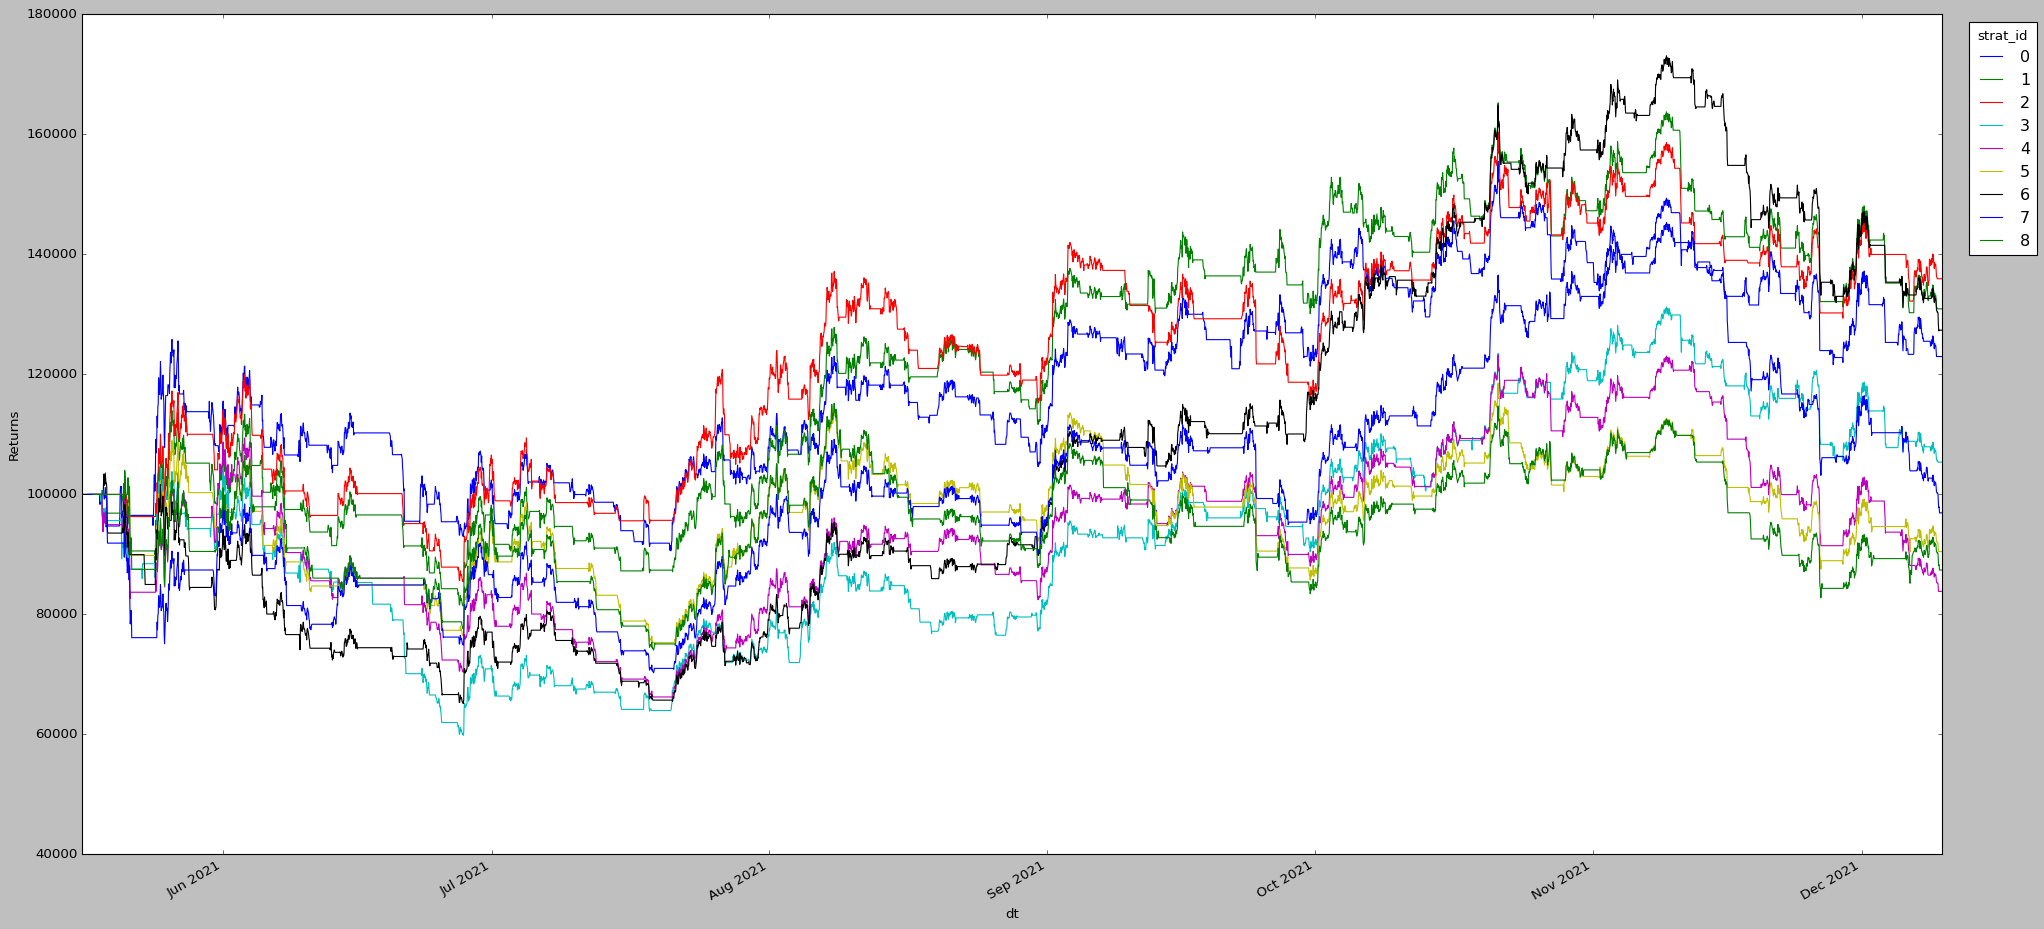

In [163]:
key = 'strat_id'
periodic = history['periodic']
g = periodic.set_index('dt').groupby(key)
axs = g.portfolio_value.plot(legend=key)
axs[0].set_ylabel('Returns')
axs[0].legend(g.groups, title=key, bbox_to_anchor=(1.01, 1), loc='upper left')

# Estratégia multi sinal

In [164]:
# essa estratégia usa varios sinais(Cruzamento de média movel e RSI)
from fastquant import backtest

strats= {
       'smac': {
           'fast_period': 7, 
           'slow_period': 60
            },
        'rsi': {
            'rsi_upper': 70,
            'rsi_lower': 30 
        }
   }
results, history = backtest('multi', 
                               crypto, 
                               strats=strats,
                               plot=False,
                               verbose=False,
                               return_history=True
                              )

2021-12-10T00:00:00, ===Global level arguments===
2021-12-10T00:00:00, init_cash : 100000
2021-12-10T00:00:00, buy_prop : 1
2021-12-10T00:00:00, sell_prop : 1
2021-12-10T00:00:00, commission : 0
2021-12-10T00:00:00, stop_loss : 0
2021-12-10T00:00:00, stop_trail : 0
2021-12-10T00:00:00, take_profit : 0
===Strategy level arguments===
fast_period : 7
slow_period : 60
2021-12-10T00:00:00, ===Global level arguments===
2021-12-10T00:00:00, init_cash : 100000
2021-12-10T00:00:00, buy_prop : 1
2021-12-10T00:00:00, sell_prop : 1
2021-12-10T00:00:00, commission : 0
2021-12-10T00:00:00, stop_loss : 0
2021-12-10T00:00:00, stop_trail : 0
2021-12-10T00:00:00, take_profit : 0
===Strategy level arguments===
rsi_period : 14
rsi_upper : 70
rsi_lower : 30
2021-05-15T16:00:00, BUY CREATE, 3771.61
2021-05-15T16:00:00, Cash: 100000.0
2021-05-15T16:00:00, Price: 3771.61
2021-05-15T16:00:00, Buy prop size: 26.487388648375603
2021-05-15T16:00:00, Afforded size: 26.487388648375603
2021-05-15T16:00:00, Final siz

In [165]:
results

,strat_id,init_cash,buy_prop,sell_prop,smac.fractional,smac.slippage,smac.single_position,smac.commission,smac.stop_loss,smac.stop_trail,smac.take_profit,execution_type,smac.channel,smac.symbol,smac.allow_short,smac.short_max,smac.add_cash_amount,smac.add_cash_freq,smac.invest_div,smac.fast_period,smac.slow_period,rsi.fractional,rsi.slippage,rsi.single_position,rsi.commission,rsi.stop_loss,rsi.stop_trail,rsi.take_profit,rsi.channel,rsi.symbol,rsi.allow_short,rsi.short_max,rsi.add_cash_amount,rsi.add_cash_freq,rsi.invest_div,rsi.rsi_period,rsi.rsi_upper,rsi.rsi_lower,rtot,ravg,rnorm,rnorm100,len,drawdown,moneydown,max,maxdrawdown,maxdrawdownperiod,sharperatio,pnl,final_value,total,win_rate,won,lost,won_avg,won_avg_prcnt,lost_avg,lost_avg_prcnt,won_max,won_max_prcnt,lost_max,lost_max_prcnt
0,0,100000,1,1,False,0.001,None,0,0,0,0,close,,,False,1.5,0,M,True,7,60,False,0.001,None,0,0,0,0,,,False,1.5,0,M,True,14,70,30,-0.029795,-0.000142,-0.035123,-3.512261,4979,5.278636,5409.21,"{'len': 4979, 'drawdown': 42.714165320954685, ...",40.3727,209,None,-2935.57,97064.43,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


ROI de -3%

In [166]:
orders = history['orders']
orders.strat_id.unique(), orders.strat_name.unique()

(array([0]),
 array(['smac.fast_period7_slow_period60', 'rsi.rsi_upper70_rsi_lower30'],
       dtype=object))

In [167]:
from fastquant import backtest

strats= {
       'smac': {
           'fast_period': [7,14], 
           'slow_period': [30,60]
            },
        'rsi': {
            'rsi_upper': [70,80],
            'rsi_lower': [20,30] 
        }
   }
results, history = backtest('multi', 
                               crypto, 
                               strats=strats,
                               plot=False,
                               verbose=False,
                               return_history=True
                              )

A saída de streaming foi truncada nas últimas 5000 linhas.
2021-10-23T14:00:00, Price: 4025.3
2021-10-23T14:00:00, Buy prop size: 20.23024797724822
2021-10-23T14:00:00, Afforded size: 20.23024797724822
2021-10-23T14:00:00, Final size: 20
2021-10-23T15:00:00, BUY EXECUTED, Price: 4025.30, Cost: 80506.00, Comm: 0.00, Size: 20.00
2021-10-24T15:00:00, SELL CREATE, 4029.51
2021-10-24T16:00:00, SELL EXECUTED, Price: 4000.11, Cost: 80506.00, Comm: 0.00, Size: -20.00
2021-10-25T05:00:00, BUY CREATE, 4124.61
2021-10-25T05:00:00, Cash: 81010.45000000006
2021-10-25T05:00:00, Price: 4124.61
2021-10-25T05:00:00, Buy prop size: 19.621132780922448
2021-10-25T05:00:00, Afforded size: 19.621132780922448
2021-10-25T05:00:00, Final size: 19
2021-10-25T06:00:00, BUY EXECUTED, Price: 4124.61, Cost: 78367.59, Comm: 0.00, Size: 19.00
2021-10-25T16:00:00, SELL CREATE, 4185.40
2021-10-25T17:00:00, SELL EXECUTED, Price: 4230.42, Cost: 78367.59, Comm: 0.00, Size: -19.00
2021-10-27T06:00:00, BUY CREATE, 4240.07
2

In [168]:
orders = history['orders']
orders.strat_id.unique(), orders.strat_name.unique()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 array(['smac.fast_period7_slow_period30', 'rsi.rsi_upper70_rsi_lower20',
        'rsi.rsi_upper70_rsi_lower30', 'rsi.rsi_upper80_rsi_lower20',
        'rsi.rsi_upper80_rsi_lower30', 'smac.fast_period7_slow_period60',
        'smac.fast_period14_slow_period30',
        'smac.fast_period14_slow_period60'], dtype=object))

In [169]:
results

,strat_id,init_cash,buy_prop,sell_prop,smac.fractional,smac.slippage,smac.single_position,smac.commission,smac.stop_loss,smac.stop_trail,smac.take_profit,execution_type,smac.channel,smac.symbol,smac.allow_short,smac.short_max,smac.add_cash_amount,smac.add_cash_freq,smac.invest_div,smac.fast_period,smac.slow_period,rsi.fractional,rsi.slippage,rsi.single_position,rsi.commission,rsi.stop_loss,rsi.stop_trail,rsi.take_profit,rsi.channel,rsi.symbol,rsi.allow_short,rsi.short_max,rsi.add_cash_amount,rsi.add_cash_freq,rsi.invest_div,rsi.rsi_period,rsi.rsi_upper,rsi.rsi_lower,rtot,ravg,rnorm,rnorm100,len,drawdown,moneydown,max,maxdrawdown,maxdrawdownperiod,sharperatio,pnl,final_value,total,win_rate,won,lost,won_avg,won_avg_prcnt,lost_avg,lost_avg_prcnt,won_max,won_max_prcnt,lost_max,lost_max_prcnt
0,6,100000,1,1,False,0.001,None,0,0,0,0,close,,,False,1.5,0,M,True,7,60,False,0.001,None,0,0,0,0,,,False,1.5,0,M,True,14,80,20,0.558567,0.002660,0.954786,95.478552,739,8.940488,17164.00,"{'len': 1672, 'drawdown': 28.943048760734033, ...",25.212187,51,None,74816.57,174816.57,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7,100000,1,1,False,0.001,None,0,0,0,0,close,,,False,1.5,0,M,True,7,60,False,0.001,None,0,0,0,0,,,False,1.5,0,M,True,14,80,30,0.482632,0.002298,0.784536,78.453592,739,6.861841,11937.61,"{'len': 1927, 'drawdown': 42.34966182522648, '...",40.058460,81,None,62033.35,162033.35,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,100000,1,1,False,0.001,None,0,0,0,0,close,,,False,1.5,0,M,True,7,30,False,0.001,None,0,0,0,0,,,False,1.5,0,M,True,14,80,20,0.423466,0.002017,0.662229,66.222890,739,17.378747,32124.45,"{'len': 1713, 'drawdown': 26.764576821113153, ...",24.288495,69,None,52724.61,152724.61,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11,100000,1,1,False,0.001,None,0,0,0,0,close,,,False,1.5,0,M,True,14,30,False,0.001,None,0,0,0,0,,,False,1.5,0,M,True,14,80,30,0.386796,0.001842,0.590671,59.067057,739,9.940135,16249.67,"{'len': 3187, 'drawdown': 42.17821975869288, '...",40.837172,133,None,47225.67,147225.67,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15,100000,1,1,False,0.001,None,0,0,0,0,close,,,False,1.5,0,M,True,14,60,False,0.001,None,0,0,0,0,,,False,1.5,0,M,True,14,80,30,0.327434,0.001559,0.481301,48.130096,209,14.903144,24297.81,"{'len': 2094, 'drawdown': 50.67659351224373, '...",48.274470,88,None,38740.34,138740.34,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,3,100000,1,1,False,0.001,None,0,0,0,0,close,,,False,1.5,0,M,True,7,30,False,0.001,None,0,0,0,0,,,False,1.5,0,M,True,14,80,30,0.279951,0.001333,0.399256,39.925601,739,17.580105,28220.87,"{'len': 1891, 'drawdown': 36.872246831988186, ...",33.663406,78,None,32306.44,132306.44,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,14,100000,1,1,False,0.001,None,0,0,0,0,close,,,False,1.5,0,M,True,14,60,False,0.001,None,0,0,0,0,,,False,1.5,0,M,True,14,80,20,0.222559,0.001060,0.306133,30.613314,2884,20.301519,31822.53,"{'len': 2884, 'drawdown': 31.783804950916938, ...",30.703846,70,None,24926.97,124926.97,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,10,100000,1,1,False,0.001,None,0,0,0,0,close,,,False,1.5,0,M,True,14,30,False,0.001,None,0,0,0,0,,,False,1.5,0,M,True,14,80,20,0.164159,0.000782,0.217733,21.773288,739,17.670140,25291.58,"{'len': 3632, 'drawdown': 42.910615776132374, ...",41.373852,151,None,17840.17,117840.17,2,0.0,0.0,1.0,0.0,0.0,-11975.2,-11.9752,0.0,0.0,-11975.2,-11.9752
8,4,100000,1,1,False,0.001,None,0,0,0,0,close,,,False,1.5,0,M,True,7,60,False,0.001,None,0,0,0,0,,,False,1.5,0,M,True,14,70,20,0.080432,0.000383,0.101329,10.132942,4498,15.276301,19540.89,"{'len': 4498, 'drawdown': 25.464090327140944, ...",24.696261,188,None,8375.48,108375.48,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0,100000,1,1,False,0.001,None,0,0,0,0,close,,,False,1.5,0,M,True,7,30,False,0.001,None,0,0,0,0,,,False,1.5,0,M,True,14,70,20,-0.013585,-0.000065,-0.016169,-1.616943,4739,33.201312,49032.90,"{'len': 4739, 'drawdown': 37.10787289748171, '...",31.823724,197,None,-1349.28,986

Melhor ROI foi 74 %